# Pipeline test with RCA

- Inputs:
    - 1 RCA image
    - expert annotations of the image
- Operations: 
    - **Part 1**: parameter extraction from RCA image
    - **Part 2**: blob detection on RCA image, using parameter extraction
    - **Part 3**: cropping of RCA image, using parameter extraction
    - **Part 4**: QC and reassembly of worker-annotated crops
    - **Part 5**: evaluation of precision and recall
- Outputs:
    - Consensus worker annotation coordinates
    - Precision and recall analysis


In [15]:
from sklearn.neighbors import KDTree
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import sys, os
sys.path.insert(0, '../../../../../FISH-annotation/fishanno')
import util
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation

%load_ext autoreload
%autoreload 2

## User Inputs

In [16]:
margin = 4					# margin around each spot, in pixels
correctness_threshold = 10
max_num_crops = 7
colors = ['cyan', 'blue', 'purple', 'violet', 'magenta', 'red', 'orange', 'yellow', 'green', ]    
crosshair_ratio = 0.04
max_num_crops = 4
max_crowded_ratio = 0.3
clustering_params = ['AffinityPropagation', -350]
declumping_params = ['KMeans', 2]

In [17]:
sample_img_filename = 'ISS_rnd0_ch0_z0.png'
sample_img_path = './sample_image_filtered/' + sample_img_filename
sample_coords_filename = 'ISS_rnd0_ch0_z0.csv'
sample_coords_path = './sample_image_filtered/' + sample_coords_filename

In [18]:
test_img_filenames = ['ISS_rnd0_ch1_z0', 'ISS_rnd0_ch3_z0', 'ISS_rnd1_ch1_z0']
test_img_paths = ['./test_images_filtered/images/%s.png' % x for x in test_img_filenames]
test_coords_paths = ['./test_images_filtered/coords/%s.csv' % x for x in test_img_filenames]

# Part 1: Parameter Extraction

### This section of the pipeline:

- Inputs:
    - sample FISH image
    - expert annotations of the image
- Outputs: 
    - parameters specific to RCA FISH for blob detection
        - max sigma: `max_sigma`
        - min sigma: `min_sigma`
        - optimal intensity threshold: `best_threshold`
    - these parameters are saved in ./sample_image_filtered/spot_params

### Sample image with expert annotations

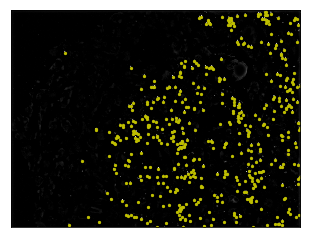

In [11]:
im = imread(sample_img_path, as_gray=True)
ref = np.asarray(pd.read_csv(sample_coords_path))
for x, y in ref:
    plt.scatter([x], [y], color='y', s=5)
plt.imshow(im, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("sample_img_w_expert.pdf", transparent=True, bbox_inches="tight")
plt.show()

### Test images

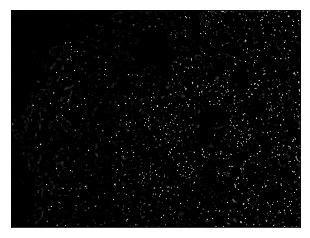

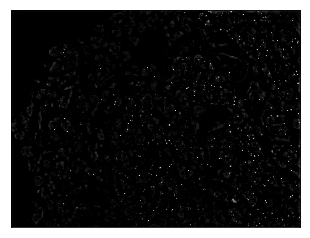

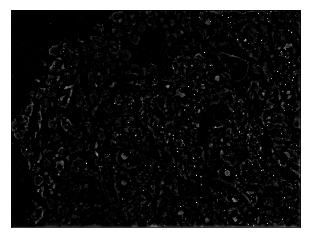

In [12]:
for i, test_img_path in enumerate(test_img_paths):
    im = imread(test_img_path, as_gray=True)
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig("test_img_%s.pdf" % i, transparent=True, bbox_inches="tight")
    plt.show()

In [47]:
if not os.path.exists('./sample_image_filtered/spot_params/'):
    os.mkdir('./sample_image_filtered/spot_params/')

# Find limits on spot size

### Find the size of each spot identified by the expert and take the max and min

In [13]:
sample_coords = np.genfromtxt(sample_coords_path, delimiter=',')[1:]
sigma_list = util.get_sigma_list(sample_img_path, sample_coords, margin)

/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


In [48]:
np.savetxt('./sample_image_filtered/spot_params/param_extraction_sigmas.csv', sigma_list, delimiter=',')

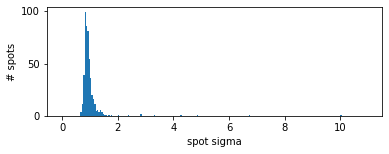

In [19]:
sigma_list = np.asarray(pd.read_csv('./sample_image_filtered/spot_params/param_extraction_sigmas.csv'))
plt.figure(figsize=(6,2))
plt.hist(sigma_list, bins=np.arange(0, 11, 0.05))
plt.yticks([0, 50, 100])
plt.xlabel('spot sigma')
plt.ylabel('# spots')
plt.savefig('spot_sigma_hist.pdf', transparent=True, bbox_inches="tight")
plt.show()

# Find the optimal intensity threshold

### Assign a range of intensity thresholds to test.

In [13]:
thresholds = np.arange(0.1, 0.4, 0.03)

### Run blob detection with a range of thresholds and evaluate precision and recall for each to find the best threshold.

In [22]:
best_threshold, best_recall, best_precision, recall_list, precision_list = util.get_best_threshold(
    sample_coords, test_img_path, min(sigma_list), max(sigma_list), correctness_threshold, thresholds)

In [49]:
np.savetxt('./sample_image_filtered/spot_params/param_extraction_precision.csv', precision_list, delimiter=',')
np.savetxt('./sample_image_filtered/spot_params/param_extraction_recall.csv', recall_list, delimiter=',')

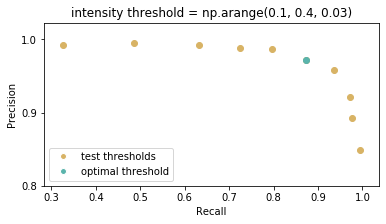

In [26]:
precision_list = np.asarray(pd.read_csv('./sample_image_filtered/spot_params/param_extraction_precision.csv'))
recall_list = np.asarray(pd.read_csv('./sample_image_filtered/spot_params/param_extraction_recall.csv'))
best_recall = recall_list[4]
best_precision = precision_list[4]

plt.figure(figsize = (6, 3))
plt.scatter(recall_list, precision_list, c='#d8b365')
plt.scatter([best_recall], [best_precision], c='#5ab4ac')
plt.xlabel('Recall')
plt.yticks([.8, .9, 1])
plt.ylabel('Precision')

handle1 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#d8b365', label='test thresholds')
handle2 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#5ab4ac', label='optimal threshold')
plt.legend(handles=[handle1, handle2], loc='lower left')

plt.title('intensity threshold = np.arange(0.1, 0.4, 0.03)')
plt.savefig('spot_intensity_hist.pdf', transparent=True, bbox_inches="tight")
plt.show()

## Print and save blob detection parameters
The min sigma, max sigma, and optimal intensity threshold found above with parameter extraction are now considered "tuned" parameters. 
If we are satisfied with them, we can use them with blob_log() on other smFISH chemistries.

In [30]:
print('greatest spot_sigma = %f' % (round(max_sigma, 2)))
print('smallest spot_sigma = %f' % (round(min_sigma, 2)))
print('optimal intensity threshold = %f' % (round(best_threshold, 2)))
np.savetxt('./sample_image_filtered/spot_params/' + sample_coords_filename, [[min_sigma, max_sigma, best_threshold]], header='min_sigma,max_sigma,best_threshold', delimiter=",", comments='')

greatest spot_sigma = 10.030000
smallest spot_sigma = 0.670000
optimal intensity threshold = 0.220000


# Part 2: Blob Detection

### This section of the pipeline:

- Inputs:
    - parameters specific to RCA FISH for blob detection
        - max sigma: `max_sigma`
        - min sigma: `min_sigma`
        - optimal intensity threshold: `best_threshold`
- Outputs:
    - coordinates of spots detected by blob detection

### Run blob_log() on all test images using min_sigma, max_sigma, and best_threshold found above.

In [32]:
blob_params = pd.read_csv('./sample_image_filtered/spot_params/' + sample_coords_filename)
min_sigma = blob_params['min_sigma'][0]
max_sigma = blob_params['max_sigma'][0]
best_threshold = blob_params['best_threshold'][0]

for img_path, coords_path in zip(test_img_paths, test_coords_paths):

    im = imread(img_path, as_gray=True)
    img_height = len(im)
    
    if not os.path.exists('./test_images_filtered/blobs/'):
        os.mkdir('./test_images_filtered/blobs/')
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    
    blobs_log = blob_log(im, max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=10, threshold=best_threshold)
    blobs = [[c, r] for r, c, sigma in blobs_log]
    
    np.savetxt(blob_path, blobs, header='x,y', delimiter=",", comments='')

### Plot Detected Blobs

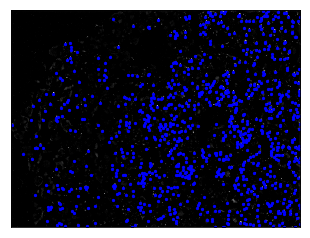

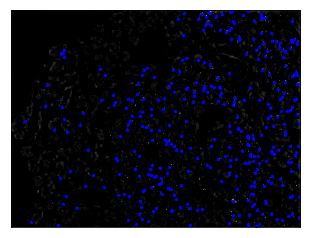

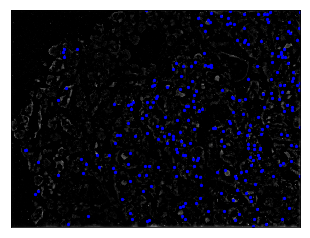

In [29]:
for i, img_path in enumerate(test_img_paths):
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    blobs = np.asarray(pd.read_csv(blob_path))
    
    plt.figure()
    im = imread(img_path)
    plt.imshow(im, cmap='gray')
    for x, y in blobs:
        plt.scatter([x], [y], color='blue', s=5)
    plt.xlim(0, im.shape[1])
    plt.ylim(0, im.shape[0])
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.savefig("blobs_%s.pdf" % i, transparent=True, bbox_inches="tight")
    plt.show()

# Part 3: Cropping

### This section of the pipeline:

- Inputs:
    - coordinates of spots detected by blob detection
- Outputs:
    - crops ready to be sent to mechanical turkers

In [46]:
if not os.path.exists('./test_images_filtered/crops/'):
    os.mkdir('./test_images_filtered/crops/')
    
for img_path, img_name in zip(test_img_paths, test_img_filenames):
    
    crops_path = './test_images_filtered/crops/%s/' % img_name
    
    if not os.path.exists(crops_path):
        os.mkdir(crops_path)
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    blobs = np.asarray(pd.read_csv(blob_path))

    image_width = imread(img_path).shape[1]
    crosshair_arm_length = crosshair_ratio * image_width
    
    util.autocrop(blobs, img_name, crosshair_arm_length, max_num_crops, max_crowded_ratio)
    

Plot crops for ISS_rnd0_ch3_z0

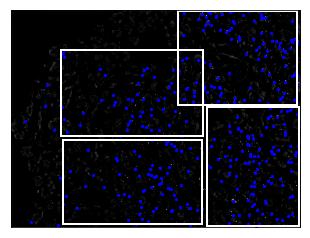

In [31]:
img_path = test_img_paths[1]
blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
test_img_filename = test_img_filenames[1]
blobs = np.asarray(pd.read_csv(blob_path))

fig,ax = plt.subplots(1)
im = imread(img_path)
plt.imshow(im, cmap='gray')
for x, y in blobs:
    plt.scatter([x], [y], color='blue', s=5)
plt.xlim(0, im.shape[1])
plt.ylim(0, im.shape[0])

for j in range(4):
    csv_path = './crops/%s/%s_%s.csv' % (test_img_filename, test_img_filename, j)
    crop = np.genfromtxt(csv_path, delimiter=',')
    rect = Rectangle((crop[0], crop[2]), crop[1]-crop[0], crop[3]-crop[2], edgecolor='w', facecolor='none', linewidth=2)
    ax.add_patch(rect)

plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.savefig('blobs_w_crops.pdf', transparent=True, bbox_inches="tight")
plt.show()

# Part 4: QC and Reassembly

### This section of the pipeline:

- Inputs:
    - annotations from Quanti.us for each crop
- Outputs:
    - total consensus annotations for each image

Plot annotations for crops of ISS_rnd0_ch3_z0 

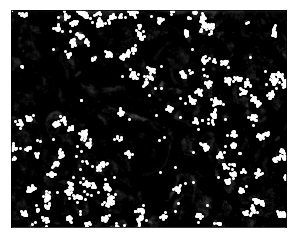

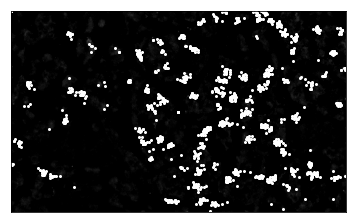

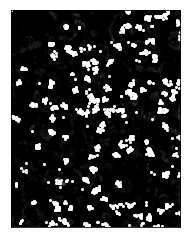

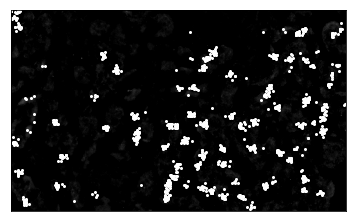

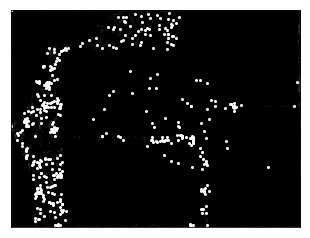

In [49]:
test_img_filename = 'ISS_rnd0_ch3_z0'
crops_path = './crops/%s/' % test_img_filename
consensus_path = './consensus/%s/' % test_img_filename
json_filepath = './anno/%s.json' % test_img_filename

crop_names = ['%s_%s.png' % (test_img_filename, ind) for ind in range(4)]
crop_names.append('%s_blacked.png' % test_img_filename)
for crop_name in crop_names:
    plt.figure()
    qa = QuantiusAnnotation(json_filepath, crop_name)
    sa = SpotAnnotationAnalysis(qa)
    anno_all = qa.df()
    x_vals = list(anno_all['x'])
    im = imread(crops_path + crop_name, as_gray=True)
    img_height = len(im)
    y_vals = [img_height - y for y in list(anno_all['y'])]
    plt.scatter(x_vals, y_vals, color='white', s=4)
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('consensus_%s.pdf' % crop_name, transparent=True, bbox_inches="tight")
    plt.show()

### QC, save consensus coords

In [34]:
if not os.path.exists('./consensus/'):
    os.mkdir('consensus')

In [101]:
test_img_filenames = ['ISS_rnd0_ch1_z0']

In [102]:
for test_img_filename in test_img_filenames:
    crops_path = './crops/%s/' % test_img_filename
    json_filepath = './anno/%s.json' % test_img_filename
    img_filenames = [f for f in os.listdir(crops_path) if f.endswith('.png')]

    for img_filename in img_filenames:

        print('Now processing %s' % (img_filename))

        img_filepath = './crops/%s/%s' % (test_img_filename, img_filename)

        qa = QuantiusAnnotation(json_filepath, img_filename)
        sa = SpotAnnotationAnalysis(qa)
        anno_all = qa.df()

        # cluster annotations
        clusters = sa.get_clusters(anno_all, clustering_params)  

        # apply QC
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)

        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        clusters_post_qc = nonclumpy_clusters

        if len(clumpy_clusters.index) is not 0:
            for i in range(len(clumpy_clusters.index)):
                subclusters = util.declump(clumpy_clusters, i, declumping_params)
            clusters_post_qc = pd.concat([subclusters, clusters_post_qc], ignore_index=True)

        # save consensus coords        
        im = imread(img_filepath)
        img_height = len(im)
        clusters_post_qc_list = []
        for index in clusters_post_qc.index:
            row = clusters_post_qc.iloc[index]
            x, y = row['centroid_x'], row['centroid_y']
            clusters_post_qc_list.append([x, img_height-y])
        path = ('./consensus/%s' % img_filename).replace('png', 'csv')
        np.savetxt(path, np.asarray(clusters_post_qc_list), delimiter=",", comments='', header='centroid_x,centroid_y')


Now processing ISS_rnd0_ch1_z0_3.png
Now processing ISS_rnd0_ch1_z0_2.png
Now processing ISS_rnd0_ch1_z0_0.png
Now processing ISS_rnd0_ch1_z0_1.png
Now processing ISS_rnd0_ch1_z0_2_0.png
Now processing ISS_rnd0_ch1_z0_2_1.png
Now processing ISS_rnd0_ch1_z0_2_3.png
Now processing ISS_rnd0_ch1_z0_2_2.png
Now processing ISS_rnd0_ch1_z0_2_blacked.png
Now processing ISS_rnd0_ch1_z0_blacked.png


## Reassembly of consensus coords, save reassembled coords

Reassemble deep crop

In [132]:
test_img_filename = 'ISS_rnd0_ch1_z0'
crops_path = './crops/%s/' % test_img_filename
consensus_path = './consensus/%s/' % test_img_filename
consensus_csv_names = [f for f in os.listdir(consensus_path) if f.endswith('.csv')]

Reassemble deepest level

In [134]:
consensus_csv_names_deep = [f for f in consensus_csv_names if f.startswith('ISS_rnd0_ch1_z0_2')]
total_deep = np.asarray(pd.read_csv('/Users/jenny.vo-phamhi/Documents/fish_annotation_paper/pipeline_testing/RCA/consensus/ISS_rnd0_ch1_z0/ISS_rnd0_ch1_z0_2_blacked.csv')).tolist()
for i in range(max_num_crops):
    name = 'ISS_rnd0_ch1_z0_2_' + str(i) + '.csv'
    coords = np.asarray(pd.read_csv(consensus_path + name)) # flag
    stats = np.asarray(pd.read_csv(crops_path + name, header = None))
    xmin = float(stats[0][0])
    ymin = float(stats[2][0])
    ymax = float(stats[3][0])
    height = ymax - ymin
    zoom_factor = stats[4][0]

    for coord in coords:
        x = coord[0]/zoom_factor + xmin
        y = coord[1]/zoom_factor + ymin
        total_deep.append([x, y])
        
np.savetxt('./consensus/ISS_rnd0_ch1_z0/ISS_rnd0_ch1_z0_2.csv', np.asarray(total_deep), delimiter=",", comments='', header='centroid_x,centroid_y')

Reassemble top level

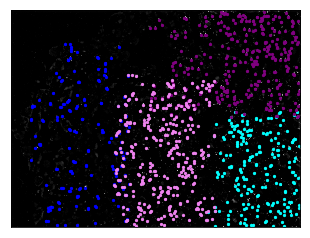

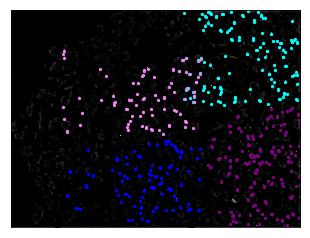

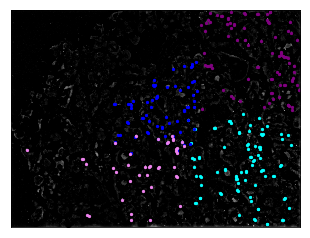

In [50]:
for test_img_filename in test_img_filenames:
    test_img_path = './test_images_filtered/images/%s.png' % test_img_filename
    blacked_path = './consensus/' + test_img_filename + '/' + test_img_filename + '_blacked.csv'
    total = []
    coords_blacked = np.asarray(pd.read_csv(blacked_path))

    for coord in coords_blacked:
        plt.scatter(coord[0], coord[1], color = 'black')
        total.append([coord[0], coord[1]])

    for i in range(4):
        coords_path = './consensus/' + test_img_filename + '/' + test_img_filename + '_' + str(i) + '.csv'
        coords = np.asarray(pd.read_csv(coords_path))
        stats_path = './crops/' + test_img_filename + '/' + test_img_filename + '_' + str(i) + '.csv'
        stats = np.asarray(pd.read_csv(stats_path, header = None))
        xmin = stats[0][0]
        ymin = stats[2][0]
        ymax = stats[3][0]
        height = ymax - ymin
        zoom_factor = stats[4][0]

        refit = []
        for coord in coords:
            x = coord[0]/zoom_factor + xmin
            y = coord[1]/zoom_factor + ymin
            refit.append([x, y])
            total.append([x, y])
        refit = np.asarray(refit)

        for coord in refit:
            plt.scatter(coord[0], coord[1], color=colors[i], s=5)

    im = imread(test_img_path, as_gray=True)
    plt.imshow(im, cmap='gray')
    
    plt.xticks([])
    plt.yticks([])
    plt.savefig('consensus_%s.pdf' % test_img_filename, transparent=True, bbox_inches="tight")
#     np.savetxt('./consensus/' + test_img_filename + '/total.csv', np.asarray(total), delimiter=",", comments='', header='centroid_x,centroid_y')
    plt.show()

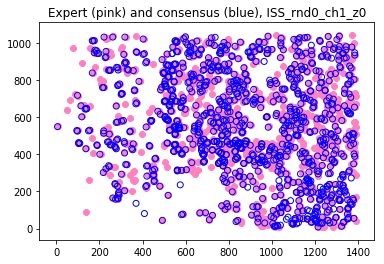

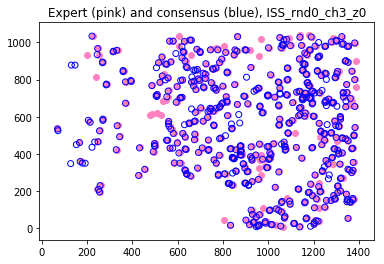

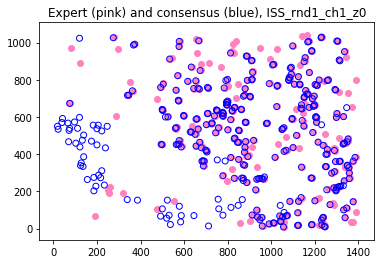

In [9]:
for test_img_filename in test_img_filenames:

    reference_filepath = './test_images_filtered/coords/%s.csv' % test_img_filename
    reference_coords = np.asarray(pd.read_csv(reference_filepath))
    consensus_total_path = './consensus/%s/total.csv' % test_img_filename
    consensus_coords = np.asarray(pd.read_csv(consensus_total_path))
    
    plt.figure()
    for x, y in reference_coords:
        plt.scatter([x], [y], c='xkcd:pink')
    
    for x, y in consensus_coords:
        plt.scatter([x], [y], edgecolor='blue', facecolor='None')
        
    plt.title('Expert (pink) and consensus (blue), %s' % test_img_filename)    
    plt.show()


# Part 5: Evaluation 

## Consensus vs. Reference

-----------------

ISS_rnd0_ch1_z0

-----------------


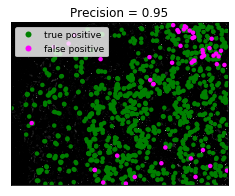

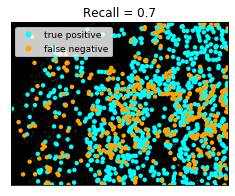

-----------------

ISS_rnd0_ch3_z0

-----------------


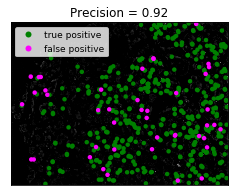

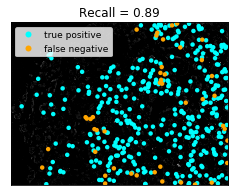

-----------------

ISS_rnd1_ch1_z0

-----------------


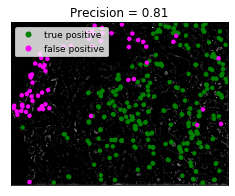

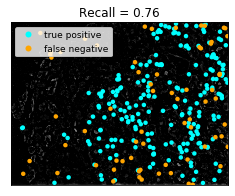

In [25]:
for test_img_filename in test_img_filenames:
    
    print('-----------------\n\n%s\n\n-----------------' % test_img_filename)
    
    test_img_filepath = './test_images_filtered/images/%s.png' % test_img_filename
    im = imread(test_img_filepath)
    img_height = len(im)
    
    reference_filepath = './test_images_filtered/coords/%s.csv' % test_img_filename
    reference_coords = np.asarray(pd.read_csv(reference_filepath))
    reference_kdt = KDTree(reference_coords, leaf_size=2, metric='euclidean')
    
    consensus_total_path = './consensus/%s/total.csv' % test_img_filename
    consensus_coords = np.asarray(pd.read_csv(consensus_total_path))
    consensus_kdt = KDTree(consensus_coords, leaf_size=2, metric='euclidean')
    
    correct_consensus = []
    incorrect_consensus = []
    detected_reference = []
    undetected_reference = []

    # correct vs. incorrect

    for consensus_coord in consensus_coords:
        dist, ind = reference_kdt.query([consensus_coord], k=1)
        if dist[0][0] < correctness_threshold:
            correct_consensus.append(consensus_coord)
        else:
            incorrect_consensus.append(consensus_coord)

    # detected vs. undetected

    for reference_coord in reference_coords:
        dist, ind = consensus_kdt.query([reference_coord], k=1)
        if dist[0][0] < correctness_threshold:
            detected_reference.append(reference_coord)
        else:
            undetected_reference.append(reference_coord)
    
    precision = len(correct_consensus)/len(consensus_coords)
    recall = len(detected_reference)/len(reference_coords)
    
    markersize = 20
    
    # plot Precision
    plt.figure(figsize=(5,3))
    for x, y in correct_consensus:
        plt.scatter(x, y, edgecolors='None', facecolors='green', s=markersize)
    for x, y in incorrect_consensus:
        plt.scatter(x, y, edgecolors='None', facecolors='magenta', s=markersize)
        
    handle1 = Line2D([0],[0], marker='o', color='None', markerfacecolor='green', markeredgecolor='None', label='true positive')
    handle2 = Line2D([0],[0], marker='o', color='None', markerfacecolor='magenta', markeredgecolor='None', label='false positive')
    legend = plt.legend(handles=[handle1, handle2], loc='upper left', frameon=1, prop={'size': 9})
    frame = legend.get_frame()
    frame.set_facecolor('white')
        
    plt.gca().invert_yaxis()
    plt.imshow(im, cmap='gray')
    title = 'Precision = %s' % round(precision, 2)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(test_img_filename + ' ' + title + '.pdf', transparent=True, bbox_inches="tight")
    plt.show()
    
    # plot Recall
    plt.figure(figsize=(5,3))
    for x, y in detected_reference:
        plt.scatter(x, y, edgecolors='None', facecolors='cyan', s=markersize)
    for x, y in undetected_reference:
        plt.scatter(x, y, edgecolors='None', facecolors='orange', s=markersize)
        
    handle1 = Line2D([0],[0], marker='o', color='None', markerfacecolor='cyan', markeredgecolor='None', label='true positive')
    handle2 = Line2D([0],[0], marker='o', color='None', markerfacecolor='orange', markeredgecolor='None', label='false negative')
    legend = plt.legend(handles=[handle1, handle2], loc='upper left', frameon=1, prop={'size': 9})
    frame = legend.get_frame()
    frame.set_facecolor('white')
    
    plt.gca().invert_yaxis()
    plt.imshow(im, cmap='gray')
    title = 'Recall = %s' % round(recall, 2)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(test_img_filename + ' ' + title + '.pdf', transparent=True, bbox_inches="tight")
    plt.show()

## Blob Detection vs. Reference

-----------------

ISS_rnd0_ch1_z0

-----------------


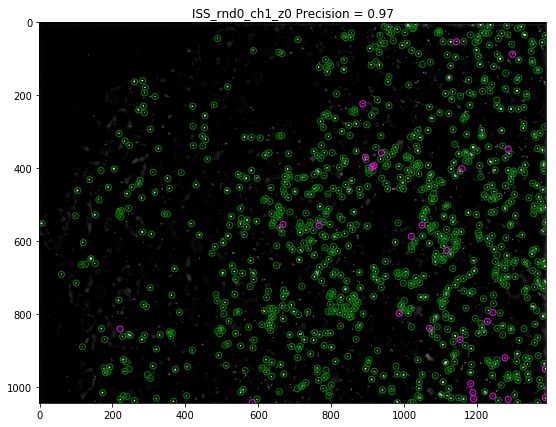

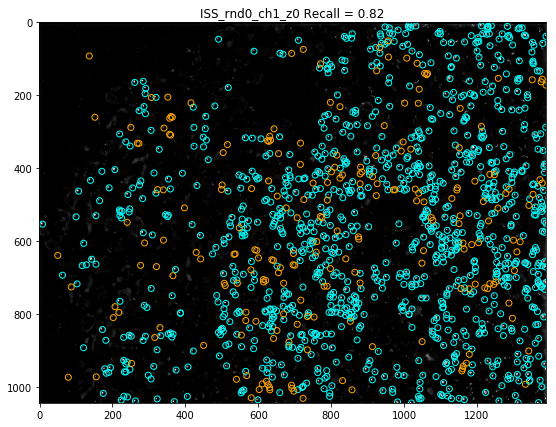

-----------------

ISS_rnd0_ch3_z0

-----------------


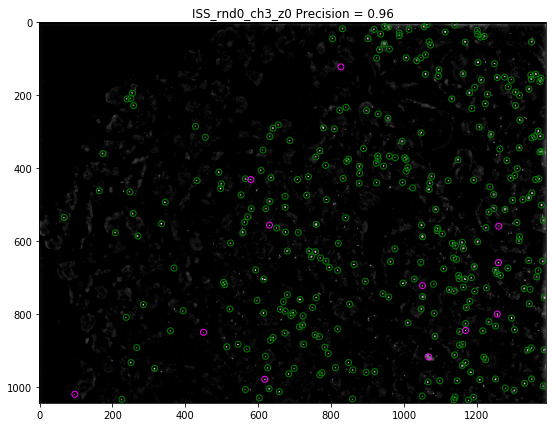

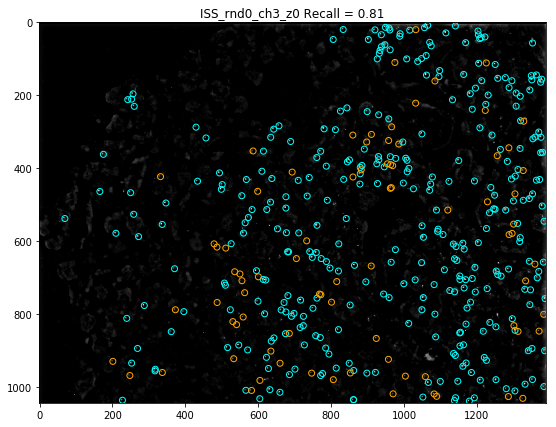

-----------------

ISS_rnd1_ch1_z0

-----------------


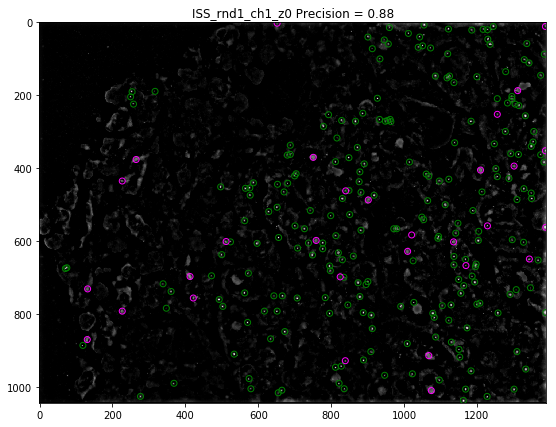

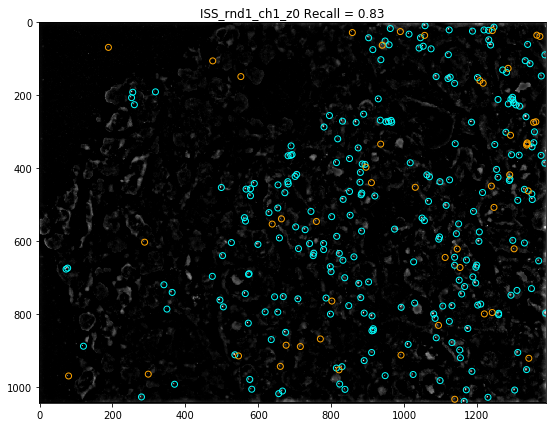

In [13]:
for test_img_filename in test_img_filenames:
    
    print('-----------------\n\n%s\n\n-----------------' % test_img_filename)
    
    test_img_filepath = './test_images_filtered/images/%s.png' % test_img_filename
    im = imread(test_img_filepath)
    img_height = len(im)
    
    reference_filepath = './test_images_filtered/coords/%s.csv' % test_img_filename
    reference_coords = np.asarray(pd.read_csv(reference_filepath))
    reference_kdt = KDTree(reference_coords, leaf_size=2, metric='euclidean')
    
    blob_total_path = './test_images_filtered/blobs/%s.csv' % test_img_filename
    blob_coords = np.asarray(pd.read_csv(blob_total_path))
    blob_kdt = KDTree(blob_coords, leaf_size=2, metric='euclidean')
    
    correct_blob = []
    incorrect_blob = []
    detected_reference = []
    undetected_reference = []

    # correct vs. incorrect

    for blob_coord in blob_coords:
        dist, ind = reference_kdt.query([blob_coord], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blob.append(blob_coord)
        else:
            incorrect_blob.append(blob_coord)

    # detected vs. undetected

    for reference_coord in reference_coords:
        dist, ind = blob_kdt.query([reference_coord], k=1)
        if dist[0][0] < correctness_threshold:
            detected_reference.append(reference_coord)
        else:
            undetected_reference.append(reference_coord)
    
    precision = len(correct_blob)/len(blob_coords)
    recall = len(detected_reference)/len(reference_coords)
    
    # plot Precision
    plt.figure(figsize=(12,7))
    for x, y in correct_blob:
        plt.scatter(x, y, edgecolors='green', facecolors='None')
    for x, y in incorrect_blob:
        plt.scatter(x, y, edgecolors='magenta', facecolors='None')
    plt.gca().invert_yaxis()
    plt.imshow(im, cmap='gray')
    plt.title('%s Precision = %s' % (test_img_filename, round(precision, 2)))
    plt.show()
    
    # plot Recall
    plt.figure(figsize=(12,7))
    for x, y in detected_reference:
        plt.scatter(x, y, edgecolors='cyan', facecolors='None')
    for x, y in undetected_reference:
        plt.scatter(x, y, edgecolors='orange', facecolors='None')
    plt.gca().invert_yaxis()
    plt.imshow(im, cmap='gray')
    plt.title('%s Recall = %s' % (test_img_filename, round(recall, 2)))
    plt.show()